# Quandela Training Seminar - Programming with Perceval

### Differential equation resolution

Differential equations are used to describe variables that continuously vary with respect to a change in other variables. These equations can be used to model the behaviours of complex systems. A simple example of this can be found in economics, where we wish to study the relationships between some variables and predict their future behaviours.

#### Introduction

We present here a Perceval implementation of a Quantum Machine Learning algorithm for solving differential equations. Its aim is to approximate the solution to the differential equation considered in [1]:

$$\frac{df}{dx}+\lambda f(x)(\kappa+tan(\lambda x))=0$$

with boundary condition $f(0)=f_0$. The analytical solution is $f(x)=f_0\;exp(-\kappa \lambda x) cos(\lambda x)$.

#### QML loss function definition

In order to use QML to solve this differential equation, we first need to derive a loss function from it whose minimum is associated to the differential equation's analytical solution.

Let $F[\{d^mf/dx^m\}_m,f,x]=0$ be a general differential equation verified by $f(x)$, where $F[.]$ is an operator acting on $f(x)$, its derivatives and $x$. For the solving of a differential equation, the loss function described in [1] consists of two terms $$\mathcal{L}_{\theta}[\{d^mg/dx^m\}_m,g,x]=\mathcal{L}_{\theta}^{(diff)}[\{d^mg/dx^m\}_m,g,x]+\mathcal{L}_{\theta}^{(boundary)}[g,x].$$

The first term $\mathcal{L}_{\theta}^{(diff)}$ corresponds to the differential equation which has been discretised over a fixed regular grid of M points noted $x_i$: $$\mathcal{L}_{\theta}^{(diff)}[\{d^mg/dx^m\}_m,g,x]=\frac{1}{M}\sum_{i=1}^{M}L(F[d_x^mg(x_i),g(x_i),x_i],0),$$

where $L(a,b)=(a-b)^2$ is the squared distance between two arguments. The second term $\mathcal{L}_{\theta}^{(boundary)}$ is associated with the initial conditions of our desired solution. It is defined as: $$\mathcal{L}_{\theta}^{(boundary)}[g,x]=\eta L(g(x_0),f_0),$$

where $\eta$ is the weight granted to the boundary condition and $f_0$ is given by $f(x_0)=f_0$.

Given a function approximator $f^{(n)}(x,\pmb{\theta},\pmb{\lambda})$, the loss function above will be minimised using a classical algorithm, updating the parameters $\pmb{\theta}$ based on samples obtained using a quantum device.

#### Quantum circuit architecture

The feature map used is presented in [2,3,4]. The quantum circuit architecture from [4] is expressed as $\mathcal{U}(x,\pmb{\theta})=\mathcal{W}^{(2)}(\pmb{\theta}_2)\mathcal{S}(x)\mathcal{W}^{(1)}(\pmb{\theta}_1)$. The phase-shift operator $\mathcal{S}(x)$ incorporates the $x$ dependency of the function we wish to approximate. It is sandwiched between two universal interferometers $\mathcal{W}^{(1)}(\pmb{\theta}_1)$ and $\mathcal{W}^{(2)}(\pmb{\theta}_2)$, where the beam splitter parameters $\pmb{\theta}_1$ and $\pmb{\theta}_2$ of this mesh architecture are tunable to enable training of the circuit. The output measurement operator, noted $\mathcal{M}(\pmb{\lambda})$ is the projection on the Fock states obtained using photon-number resolving detectors, multiplied by some coefficients $\pmb{\lambda}$ which can also be tunable. Formally, we have:

$$    \mathcal{M}(\boldsymbol{\lambda}) = \sum_{\mathbf{\left | n^{(f)}\right \rangle}}\lambda_{\mathbf{\left | n^{(f)}\right \rangle}}\mathbf{\left | n^{(f)}\right \rangle}\mathbf{\left \langle n^{(f)}\right |},
$$

where the sum is taken over all $\binom{n+m-1}{n}$ possible Fock states considering $n$ photons in $m$ modes. Let $\mathbf{\left | n^{(i)}\right \rangle} = \left |n^{(i)}_1,n^{(i)}_2,\dots,n^{(i)}_m\right \rangle$ be the input state consisting of $n$ photons where $n^{(i)}_j$ is the number of photons in input mode $j$. Given these elements, the circuit's output $f^{(n)}(x, \boldsymbol{\theta}, \boldsymbol{\lambda})$ is given by the following expectation value:

$$
f^{(n)}(x, \boldsymbol{\theta}, \boldsymbol{\lambda})=\left\langle\mathbf{n}^{(i)}\left|\mathcal{U}^{\dagger}(x, \boldsymbol{\theta}) \mathcal{M}(\boldsymbol{\lambda}) \mathcal{U}(x, \boldsymbol{\theta})\right| \mathbf{n}^{(i)}\right\rangle.
$$

This expression can be rewritten as the following Fourier series \[4\]

$$
f^{(n)}(x, \boldsymbol{\theta}, \boldsymbol{\lambda})=\sum_{\omega \in \Omega_{n}} c_{\omega}(\boldsymbol{\theta}, \boldsymbol{\lambda}) e^{i \omega x},
$$

where $\Omega_n = \{-n, -n+1, \dots, n-1, n \}$ is the frequency spectrum one can reach with $n$ incoming photons and $\{c_\omega(\boldsymbol{\theta}, \boldsymbol{\lambda})\}$ are the Fourier coefficients. The $\boldsymbol{\lambda}$ parameters are sampled randomly in the interval $[-a;a]$, with $a$ a randomly chosen integer. $f^{(n)}(x, \boldsymbol{\theta}, \boldsymbol{\lambda})$ will serve as a function approximator for this chosen differential equation. Differentiation in the loss function is discretised as $\frac{df}{dx} \simeq \frac{f(x+\Delta x) - f(x-\Delta x)}{2\Delta x}$.

$n, m,$ and $\boldsymbol{\lambda}$ are variable parameters defined below. $\Delta x$ is the mesh size.

## Perceval Simulation

### Initialisation

In [1]:
import perceval as pcvl
import numpy as np
from math import comb
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm as tqdm

We will run this notebook with 4 photons. We could use more photons, but the result with 4 photons is already satisfying.

In [2]:
nphotons = 4

### Differential equation parameters

We define here the value of the differential equation parameters and boundary condition $\lambda, \kappa, f_0$.

In [3]:
# Differential equation parameters
lambd = 8
kappa = 0.1

def F(u_prime, u, x): # DE, works with numpy arrays
    return u_prime + lambd * u * (kappa + np.tan(lambd * x))

# Boundary condition (f(x_0)=f_0)
x_0 = 0
f_0 = 1

In [4]:
# Modeling parameters
n_grid = 50    # number of grid points of the discretized differential equation
range_min = 0  # minimum of the interval on which we wish to approximate our function
range_max = 1  # maximum of the interval on which we wish to approximate our function
X = np.linspace(range_min, range_max-range_min, n_grid)  # Optimisation grid

In [5]:
# Differential equation's exact solution - for comparison
def u(x):
    return np.exp(- kappa*lambd*x)*np.cos(lambd*x)

In [6]:
# Parameters of the quantum machine learning procedure
N = nphotons              # Number of photons
m = nphotons              # Number of modes
eta = 5                   # weight granted to the initial condition
a = 200                   # Approximate boundaries of the interval that the image of the trial function can cover
fock_dim = comb(N + m - 1, N)
# lambda coefficients for all the possible outputs
lambda_random = 2 * a * np.random.rand(fock_dim) - a
# dx serves for the numerical differentiation of f
dx = (range_max-range_min) / (n_grid - 1)

In [7]:
# Input state with N photons and m modes
input_state = pcvl.BasicState([1]*N+[0]*(m-N))
print(input_state)

|1,1,1,1>


## Definition of the circuit

We will generate a Haar-random initial unitary using QR decomposition built in Perceval `Matrix.random_unitary`, the circuit is defined by the combination of 3 sub-circuits - the intermediate phase is a parameter.

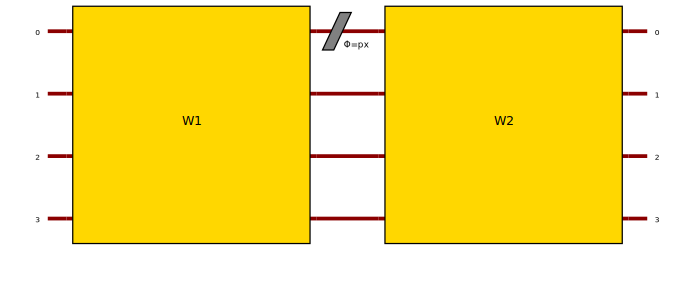

In [8]:
"Haar unitary parameters"
# number of parameters used for the two universal interferometers (2*m**2 per interferometer)
parameters = np.random.normal(size=4*m**2)

px = pcvl.P("px")
c = pcvl.Unitary(pcvl.Matrix.random_unitary(m, parameters[:2 * m ** 2]), name="W1")\
     // (0, pcvl.PS(px))\
     // pcvl.Unitary(pcvl.Matrix.random_unitary(m, parameters[2 * m ** 2:]), name="W2")

backend = pcvl.BackendFactory().get_backend("SLOS")
backend.set_circuit(pcvl.Unitary(pcvl.Matrix.random_unitary(m)))
backend.preprocess([input_state])

pcvl.pdisplay(c)

### Expectation value and loss function computation

The expectation value of the measurement operator $\mathcal{M}(\boldsymbol{\lambda})$ is obtained directly from Fock state probabilities computed by Perceval. Given this expectation value, the code snippet below computes the loss function defined in the Introduction.

Note the use of the `all_prob` simulator method giving directly access to the probabilities of all possible output states, including null probabilities (probabilities of observing the state with m modes and 0 photons as all photons were lost). This calculation is optimized in the SLOS backend.

In [9]:
def computation(params):
    global current_loss
    global computation_count
    "compute the loss function of a given differential equation in order for it to be optimized"
    computation_count += 1
    f_theta_0 = 0  # boundary condition
    coefs = lambda_random  # coefficients of the M observable
    # initial condition with the two universal interferometers and the phase shift in the middle
    U_1 = pcvl.Matrix.random_unitary(m, params[:2 * m ** 2])
    U_2 = pcvl.Matrix.random_unitary(m, params[2 * m ** 2:])

    px = pcvl.P("x")
    c = pcvl.Unitary(U_2) // (0, pcvl.PS(px)) // pcvl.Unitary(U_1)

    px.set_value(np.pi * x_0)
    backend.set_circuit(c)
    f_theta_0 = np.sum(np.multiply(backend.all_prob(input_state), coefs))

    # boundary condition given a weight eta
    loss = eta * (f_theta_0 - f_0) ** 2 * len(X)

    # Y[0] is before the domain we are interested in (used for differentiation), x_0 is at Y[1]
    Y = np.zeros(n_grid + 2)

    # x_0 is at the beginning of the domain, already calculated
    Y[1] = f_theta_0

    px.set_value(np.pi * (range_min - dx))
    backend.set_circuit(c)
    Y[0] = np.sum(np.multiply(backend.all_prob(input_state), coefs))


    for i in range(1, n_grid):
        x = X[i]
        px.set_value(np.pi * x)
        backend.set_circuit(c)
        Y[i + 1] = np.sum(np.multiply(backend.all_prob(input_state), coefs))

    px.set_value(np.pi * (range_max + dx))
    backend.set_circuit(c)
    Y[n_grid + 1] = np.sum(np.multiply(backend.all_prob(input_state), coefs))

    # Differentiation
    Y_prime = (Y[2:] - Y[:-2])/(2*dx)

    loss += np.sum((F(Y_prime, Y[1:-1], X))**2)

    current_loss = loss / len(X)
    return current_loss

### Classical optimisation

Finally the code below performs the optimisation procedure using the loss function defined in the previous section. To this end, we use a Broyden–Fletcher–Goldfarb–Shanno (BFGS) optimiser \[5\] from the SciPy library. Since we're performing the optimization classically, this is considered a hybrid quantum-classical algorithm.

In [10]:
def callbackF(parameters):
    """callback function called by scipy.optimize.minimize allowing to monitor progress"""
    global current_loss
    global computation_count
    global loss_evolution
    global start_time
    now = time.time()
    pbar.set_description("M= %d Loss: %0.5f #computations: %d elapsed: %0.5f" % 
                         (m, current_loss, computation_count, now-start_time))
    pbar.update(1)
    loss_evolution.append((current_loss, now-start_time))
    computation_count = 0
    start_time = now

In [11]:
computation_count = 0
current_loss = 0
start_time = time.time()
loss_evolution = []

pbar = tqdm.tqdm()
res = minimize(computation, parameters, callback=callbackF, method='BFGS', options={'gtol': 1E-2})

M= 4 Loss: 0.02469 #computations: 325 elapsed: 4.56400: : 85it [01:47,  2.53s/it]   

After the optimisation procedure, the optimal unitary parameters (in `res.x`) can be used to determine the quantum circuit parameters (beam-splitter reflectivity and phase-shifter angles) for an experimental realisation.

In [12]:
print("Unitary parameters", res.x)

Unitary parameters [ 1.33891468  0.18671167  0.23294109  0.66027105 -0.90538747 -0.16478482
 -1.79778695  0.27640065 -0.42235108 -0.42638238 -0.55720517 -0.50342402
  2.98759829  0.58048485 -0.05092819  1.36887037  0.76989739 -0.45710592
  0.60972939 -1.30593682  0.31607202  0.80690103 -0.07061116  1.74802391
 -0.33214799 -0.10327618 -0.09204192  0.08248837  0.44292407  1.5847011
 -0.15747674  0.20716982 -0.39656236 -2.52802577 -0.13810356  1.15592549
 -0.41093697  1.05903189  1.11363313  0.92263739 -0.85430684  0.86256034
  1.14379369  0.29563571  0.94241894 -1.00363776 -0.4509711  -1.69484381
 -0.90294638  0.76882232  0.54888516 -1.35142993 -0.25475156 -0.6617475
 -0.62901547 -0.35290343 -0.48896483 -1.07626614 -0.93944671 -0.10220152
 -0.51258919  0.07453675 -0.15409034  0.22112889]


### Plotting the approximation

We can now plot the result of our optimisation in order to compare the QML algorithm's output and the analytical solution of the differential equation.

In [13]:
def plot_solution(m, N, X, optim_params, lambda_random):
    Y = []
    U_1 = pcvl.Matrix.random_unitary(m, optim_params[:2 * m ** 2])
    U_2 = pcvl.Matrix.random_unitary(m, optim_params[2 * m ** 2:])
    px = pcvl.P("x")
    c = pcvl.Unitary(U_2) // (0, pcvl.PS(px)) // pcvl.Unitary(U_1)

    for x in X:
        px.set_value(np.pi * x)
        backend.set_circuit(c)
        f_theta = np.sum(np.multiply(backend.all_prob(input_state), lambda_random))
        Y.append(f_theta)
    exact = u(X)
    plt.plot(X, Y, label="Approximation with {} photons".format(N))

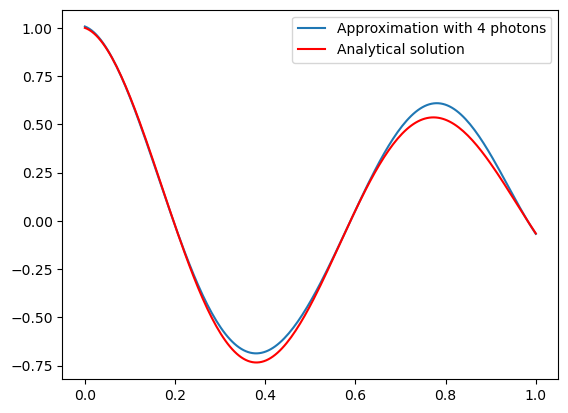

In [16]:
X = np.linspace(range_min, range_max, 200)

# Change the plot size
default_figsize = mpl.rcParamsDefault['figure.figsize']
mpl.rcParams['figure.figsize'] = [1 * value for value in default_figsize]

plot_solution(m, N, X, res.x, lambda_random)

plt.plot(X, u(X), 'r', label='Analytical solution')
plt.legend()
plt.show()

Text(0, 0.5, 'Loss function value')

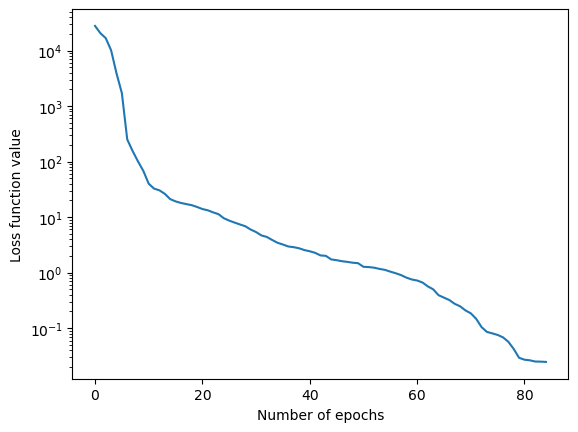

In [17]:
plt.plot([v[0] for v in loss_evolution])
plt.yscale("log")
plt.xlabel("Number of epochs")
plt.ylabel("Loss function value")

Repeating the entire computation with 3 photons would damage the accuracy of our solution but with 5 photons the accuracy would improve (the first graph above would have the two lines closer to one another). We used 4 photons as the solution is already satisfying.

Why is the accuracy lower with 3 photons? Lowering the amount of photons lowers the expressibility of our circuit, deeming our ability to find a good solution to the differential equation lower.

## References

> [1] O. Kyriienko, A. E. Paine, and V. E. Elfving, “Solving nonlinear differential equations with differentiable quantum circuits”, [Physical Review A](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.103.052416) **103**, 052416 (2021).

> [2] A. Pérez-Salinas, A. Cervera-Lierta, E. Gil-Fuster, and J. I. Latorre, “Data re-uploading for a universal quantum classifier”, [Quantum](https://quantum-journal.org/papers/q-2020-02-06-226/) **4**, 226 (2020).

> [3] M. Schuld, R. Sweke, and J. J. Meyer, “Effect of data encoding on the expressive power of variational quantum-machine-learning models”, [Physical Review A]( https://journals.aps.org/pra/abstract/10.1103/PhysRevA.103.032430) **103**, 032430 (2021).

> [4] B. Y. Gan, D. Leykam, D. G. Angelakis, and D. G. Angelakis, “Fock State-enhanced Expressivity of Quantum Machine Learning Models”, in [Conference on Lasers andElectro-Optics](https://opg.optica.org/abstract.cfm?uri=CLEO_AT-2021-JW1A.73) (2021), paper JW1A.73. Optica Publishing Group, (2021).

> [5] R. Fletcher, Practical methods of optimization. [John Wiley & Sons](https://onlinelibrary.wiley.com/doi/book/10.1002/9781118723203). (2013).